In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from scipy.optimize import newton, curve_fit, least_squares
import pickle
from numba import njit
import numba as nb
import time
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import corner as cr

from IPython.display import HTML, display
plt.style.use('../aslak.mplstyle')

/opt/anaconda3/lib/python3.12/site-packages/numba/core/cpu.py:99: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function 'betainc' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  numba.core.entrypoints.init_all()


In [2]:
#data processing functions

def MakeYearly(data):
    '''
    Takes a data array and returns the mean of the data for each year
    :param data:
    :return:
    '''
    meandata = np.mean(data[:,1:], axis = 1)
    timeseries = data[:,0]
    return meandata, timeseries

def Crop(time, precip):
    '''
    Crop the data to start at 2015
    :param time: Time array corresponding to precip indecies
    :param precip: precipitation data array
    :return: the cropped precipitation and time arrays
    '''
    index = np.where(time == 2015)
    CroppedTime = time[index[0][0]:]
    CroppedPrecip = precip[index[0][0]:]
    return CroppedPrecip, CroppedTime

def ProcessPrecipitation(data):
    '''
    :param data: Precipitation data array
    :return: Precipitation, mean thorugh the months and the deviation from the mean and cropped to start at 2015
    '''
    precip, time = MakeYearly(data)
    precip, time = Crop(time, precip)
    return precip, time

def process_temp(T):
    '''
    :param T: Temp array
    :return: Temp, mean thorugh the months and the deviation from the mean
    '''
    T_yearly = np.mean(T[:,1:], axis = 1)
    t_mean = np.mean(T_yearly[0:12])
    T_Y_deviation = T_yearly - t_mean
    return T_Y_deviation

Precip_Scenario_dict = {
    'ssp126' :  '../Cmip6_data/GFDL-ESM4/Alaska/precip/icmip6_pr_mon_GFDL-ESM4_ssp126_-176-.126E_52-69N_firstyear-lastyear_n_su_000.dat.txt',
    'ssp245' :  '../Cmip6_data/GFDL-ESM4/Alaska/precip/icmip6_pr_mon_GFDL-ESM4_ssp245_-176--126E_52-69N_firstyear-lastyear_n_su_000.dat.txt',
    'ssp370' :  '../Cmip6_data/GFDL-ESM4/Alaska/precip/icmip6_pr_mon_GFDL-ESM4_ssp370_0-360E_-90-90N_firstyear-lastyear_n_su_000.dat.txt',
    'ssp585' :  '../Cmip6_data/GFDL-ESM4/Alaska/precip/icmip6_pr_mon_GFDL-ESM4_ssp585_-176--126E_52-69N_firstyear-lastyear_n_su_000.dat.txt',
}
Tas_Scenario_dict = {
    'ssp126' :  '../Cmip6_data/GFDL-ESM4/Alaska/Tas/icmip6_tas_mon_GFDL-ESM4_ssp126_-176--127E_52-69N_firstyear-lastyear_n_000.dat.txt',
    'ssp245' :  '../Cmip6_data/GFDL-ESM4/Alaska/Tas/icmip6_tas_mon_GFDL-ESM4_ssp245_-176--127E_52-69N_firstyear-lastyear_n_002.dat.txt',
    'ssp370' :  '../Cmip6_data/GFDL-ESM4/Alaska/Tas/icmip6_tas_mon_GFDL-ESM4_ssp370_-176--126E_52-69N_firstyear-lastyear_n_000.dat.txt',
    'ssp585' :  '../Cmip6_data/GFDL-ESM4/Alaska/Tas/icmip6_tas_mon_GFDL-ESM4_ssp585_-176--126E_52-69N_firstyear-lastyear_n_000.dat.txt',
}

climate_hist_dict = {
 '1851-1870_hist' : [1851-1850, 1870-1850],
 '1901-1920_hist' : [1901-1850, 1920-1850],
 '1951-1970_hist' : [1951-1850, 1970-1850],
 '1995-2014_hist' : [1995-1850, 2014-1850],
 '2021-2040_hist' : [2021-1850, 2040-1850],
 '2041-2060_hist' : [2041-1850, 2060-1850],
 '2061-2080_hist' : [2061-1850, 2080-1850],
 '2081-2100_hist' : [2081-1850, 2100-1850],
}

def load_andprocess(scenario,period):
    """
    Load, process, and combine precipitation and temperature scenario data for a specified
    climate period. This function retrieves data paths based on the provided scenario, loads
    the data, processes it to match the given period, and converts temperatures from Kelvin
    to Celsius.

    :param scenario: The name of the climate scenario to load precipitation and temperature
        data for.
    :type scenario: str
    :param period: The name of the climate period defining the range of data to process.
    :type period: str
    :return: A combined numpy array with columns representing time, cropped precipitation,
        and cropped temperature (in Celsius).
    :rtype: numpy.ndarray
    """
    locp = Precip_Scenario_dict[scenario]
    locT = Tas_Scenario_dict[scenario]
    datp = np.loadtxt(locp, encoding='UTF-8')
    datT = np.loadtxt(locT, encoding='UTF-8')
    period = climate_hist_dict[period]
    # time = dat[period[0]:period[1],0].reshape(-1, 1)
    time = np.linspace(0, 19, num = 19*12)
    Mean_Temperature = np.mean(datT[136:2005,1:].reshape(-1, 1))+0.69-273.15
    Mean_Precipitation = np.mean(datp[136:2005,1:].reshape(-1, 1))
    croppedPrecip = np.concatenate(datp[period[0]:period[1],1:].reshape(-1, 1))
    croppedTas = np.concatenate(datT[period[0]:period[1],1:].reshape(-1, 1)) - 273.15
    out = np.column_stack((time, croppedPrecip, croppedTas))
    cal = np.array([Mean_Temperature, Mean_Precipitation])
    return out, cal

def rolling_average(array):
    if len(array)%12 == 0:
        new_array = array.reshape(-1, 12).mean(axis=1)
    else:
        cal = len(array)%12
        new_array = array[:-cal].reshape(-1, 12).mean(axis=1)
    return new_array

def get_MSE(vol):
    MSe = vol *rhoi /ocean_density /A_ocean
    return MSe

def Calculate_tau(precipitation, Region_frame):
    '''
    :param precipitation_map: A xarray dataset with precipitation data
    :param Region_frame: a pandas dataframe with the region data
    :return: responsetime tau, beta, climate sensitivity c for every time step in the precipitation map
    '''

    beta = 0.006 * np.sqrt(precipitation)
    Slope = Region_frame['slope_deg']
    c_array = []
    tau_array = []
    for i in range(precipitation):
        c = 2.3 * precipitation[i]**(0.6)/Slope
        tau = 13.6 /(beta[i] * Slope *np.sqrt((1 + 20 * Slope)* Region_frame['lmax_m']) )
        c_array.append(c)
        tau_array.append(tau)
    c = np.array(c_array).transpose()
    tau = np.array(tau_array).transpose()
    data = {
    'rgi_id': Region_frame['rgi_id'],
    'tau': tau,
    'beta': beta,
    'c': c
}
    return data



In [3]:
#Importing the glacier attributes from RGI (Region 1 Alaska)
Alaska = pd.read_csv('../Rgi/RGI2000-v7-C- Alaska/RGI2000-v7.0-G-01_alaska-attributes.csv')
glacier = Alaska.iloc[200]

In [4]:
#setting physcial constants
sec_per_year = 365.25 * 24 * 60 * 60
sec_per_month = sec_per_year/ 12
mon_year = 12 * 19
rhoi = 900  # kg_is/m3
ocean_density = 1028 #kg_ocean/m3
A_ocean = 3.625 *1e8 # area of the ocean in m2
n = 3
R = 8.31446261815324  # J/mol/K
g = 9.82
N = 50
fs = 5.7 * 1e-22
tau_0 = 1e5 # pa
sigma = 2*tau_0/(rhoi*g)
dt = 0.1
q = 2.1446847134177855
a = 8.170151901965664

In [5]:
Alaska_volume = 18.98*1e3 # km3
Alaska_area = Alaska.area_km2.sum()
Vol_area_scaling = Alaska_volume/Alaska_area
# print(Vol_area_scaling)

# simple glacier emulator

In [6]:
def dLdt(Lx: float, const: list) -> float:
    """
    Calculates the rate of change of glacier length based on cross-sectional area and physical parameters
    
    Args:
        A:Length of the glacier at time step i
        const: List of physical constants [b0, s, beta, alpha_m, cl, nu, dEdT, E0, T] where:
              b0: Maximum elevation (m)
              s: Slope (radians)
              beta: Mass balance gradient (mm/month)
              alpha_m: Shape factor
              cl: Width factor
              nu: Viscosity parameter
              dEdT: Temperature sensitivity (m/K)
              E0: Reference elevation (m)
              T: Temperature deviation (K)
    
    Returns:
        float: Rate of change of glacier length (m/month)
    """
    b0, s, beta, alpha_m, nu, dEdT, E0, T = const

    E_current = E0 + dEdT * T
    Hm = alpha_m / (1 + nu * s) * np.sqrt(Lx)
    Bs = -1 / 2 * beta * s * Lx ** 2 +  beta*(Hm + b0 - E_current) * Lx
    dldt = 2 / (3 * alpha_m * np.sqrt(Lx)) * (1 + nu * s) * Bs
    return dldt


def Get_cross_sectional_area(L: float) -> float:
    """
    Calculates glacier cross-sectional area from length
    
    Args:
        L: Glacier length (m)
        
    Returns:
        float: Cross-sectional area (m^2)
    """
    A = np.sqrt(sigma * 2) / 3 * L ** (2)
    return A


def Length_to_Volume(Length : float, a =8.170151901965664, q = 2.1446847134177855 ):
    V = a*Length**(q)
    return V

def Volume_to_Length(V:float, a =8.170151901965664, q = 2.1446847134177855):
    L = (V/a)**(1/q)
    return L

def Run_linear_model(time: np.ndarray, l0: float ,alpha_m: float,  nu: float,
                     z_offset: float, dEdT: float, df: pd.Series,
                     Precip: np.ndarray, temp: np.ndarray) -> np.ndarray:
    """
    Runs linear glacier model over time period
    
    Args:
        time: Time array (years)
        alpha_m: Shape factor
        nu: Viscosity parameter
        z_offset: Elevation offset factor
        dEdT: Temperature sensitivity (m/K)
        df: Dataframe row containing glacier parameters
        Precip: Precipitation array (mm/day)
        temp: Temperature array (°C)
        
    Returns:
        np.ndarray: Glacier volume over time (km^3)
    """
    dt = 1
    Slope_deg = df['slope_deg']
    Slope = np.arctan(Slope_deg * np.pi / 180)
    b0 = df['zmax_m']
    E = df['zmean_m'] * z_offset
    L = np.zeros_like(time)
    L[0] = l0
    beta = 0.006 * np.sqrt(Precip * 1e-3*30)
#parvec[1584.7916, 0.27035264606155984, 0.001982340525742235, 6.619695132224399, 0.2621493468101429, 54.70475404808558, 1565.9277796280246, -1.3542013157893962], DlDtnan
    for i in range(0, len(time) - 1):

        if L[i] < 25:
            L[i+1] = 0
            return Length_to_Volume(L)

        Parvector = [b0, Slope, beta[i], alpha_m, nu, dEdT, E, temp[i]]
        DlDt = dLdt(L[i], Parvector)
        L[i + 1] = L[i] + (DlDt * dt)
    Vol = Length_to_Volume(L) # Volume in m3
    return Vol

def expfunc(x,a, b, c):
    return b*np.exp(x*a) + c

def expniential_fitting(Time_data, Volume_data):
    c0 = np.min(Volume_data)
    b0 = Volume_data[0] - c0

    # Estimate a0
    a0_candidate = -0.1 # Default small decay

    if b0 > 1e-6 and (Volume_data[-1] - c0) > 1e-9 : # Ensure b0 is positive and end point is above c0 for log
        if ( (Volume_data[-1] - c0) / b0 ) > 0 :
            a0_candidate = np.log( (Volume_data[-1] - c0) /b0 ) /  (Time_data[-1] - Time_data[0])
        else:
            a0_candidate = -1.0 / (Time_data[-1] - Time_data[0])

    p0 = [
        a0_candidate if np.isfinite(a0_candidate) and a0_candidate < 0 else -0.1, # ensure decay if expected
        b0 if np.isfinite(b0) and b0 > 0 else np.std(Volume_data),
        c0 if np.isfinite(c0) else np.mean(Volume_data)
    ]


    # Example: a is negative, b is positive, c is positive and below initial max
    lower_bounds = [-np.inf, 0, 0]
    upper_bounds = [-1e-9, np.inf, Volume_data[0] if len(Volume_data)>0 else np.inf] # a is negative (not zero)




    exp_par, exp_cov = curve_fit(
        expfunc,
        xdata=Time_data,
        ydata=Volume_data,
        p0=p0,
        bounds=(lower_bounds, upper_bounds), # Use bounds
        method='trf',                       # Method that supports bounds
        maxfev=1000000                      # Increased iterations
    )
    return exp_par, exp_cov


fitted a = 8.170e+00,   fitted q = 2.0987


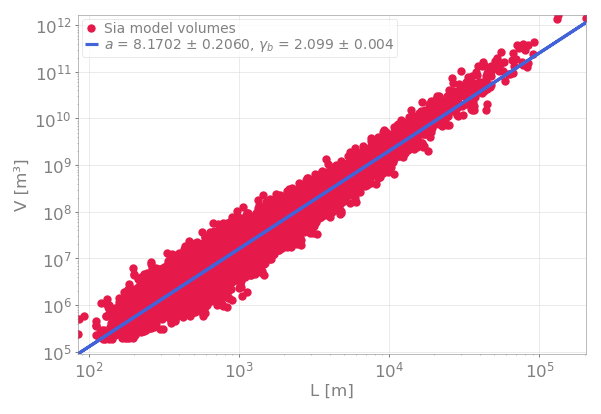

In [10]:
Areas = Alaska.area_km2
Lengths = Alaska.lmax_m
Volumes = 0.06*(Areas)**(1.26) *1e9
# linear fit: logV ≈ q * logL + loga
pars, covs = np.polyfit(np.log(Lengths), np.log(Volumes), 1, cov = True)
q = pars[0]
a = np.exp(pars[1])
q_std = np.sqrt(covs[0,0])
a_std = np.sqrt(covs[1,1]) * a
print(f"fitted a = {a:.3e},   fitted q = {q:.4f}")

# plot to check
plt.figure()
plt.loglog(Lengths, Volumes,   'o',   label='Sia model volumes')
plt.loglog(Lengths, a*Lengths**(q), '-', label=f'$a$ = {a:.4f} ± {a_std:.4f}, $\\gamma_b$ = {q:.3f} ± {q_std:.3f}')
plt.xlabel('L [m]')
plt.ylabel('V [m³]')
plt.legend()


In [57]:
a_mod = a + a_std
q_mod = q + q_std+ 0.04
minimal_volumes = a_mod*Lengths**(q_mod)
print(np.sum(minimal_volumes)*1e-12)
print(np.sum(Volumes)*1e-12)

19.968593074937882
19.963151668682173


In [22]:
# with open(f'Data_dict_ssp126_2081_2100_histalaska_PDD_Glaciers_small.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)
with open(f'SimulationData/Data_dict_ssp585_2081-2100_histalaska_PDD_Glaciers_precip_offset_test.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

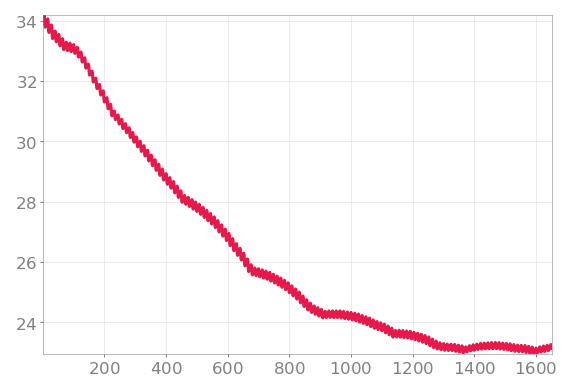

In [23]:
index = 1807
# index = 1297
glacier = Alaska.iloc[index]
periods = ['1995-2014_hist']
G_vol = loaded_data[periods[0]]['Glacier volume'][index][1:]
G_yr = loaded_data[periods[0]]['Years runtime'][index][1:]
G_Temp = loaded_data[periods[0]]['Temperature'][index][1:]
G_Precip = loaded_data[periods[0]]['Precipitation'][index][1:]

plt.plot(G_yr, G_vol*1e-9)


In [24]:
def passfunc(time, alpha_m, nu, z_offset, dEdT):
    f = Run_linear_model(time = time,
                 alpha_m = alpha_m,
                 nu = nu,
                 l0 = Volume_to_Length(G_vol[1]),
                 dEdT = dEdT,
                 z_offset= z_offset,
                 df = glacier,
                 Precip= G_Precip,
                 temp = G_Temp,
                 )
    return f

#set the lower parameter bounds
lower_bounds = [0, 0, 0, 60]
# alpha_m, nu, z_offset, dEdT
# Set upper bounds for each parameter
upper_bounds = [40, 3, 2, 120]

# Combine into the bounds parameter
bounds = (lower_bounds, upper_bounds)

par_fit, cov = curve_fit(f =passfunc, xdata=G_yr, ydata=G_vol , p0=[4,  2 , 1, 80], maxfev=100000, bounds=bounds)


In [25]:
print("alpha_m:", par_fit[0])
print("nu:", par_fit[1])
print("z_offset:", par_fit[2])
print("dEdT:",par_fit[3])

alpha_m: 12.936569792411614
nu: 1.764267000802416
z_offset: 1.0396957676028955
dEdT: 119.99999999999909


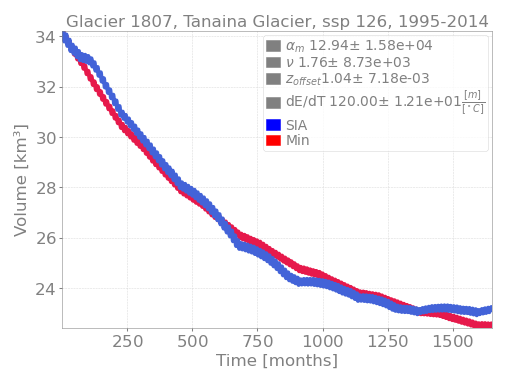

In [26]:
# glacier = Alaska.iloc[3]
Single_run = Run_linear_model(time=G_yr,l0 = Volume_to_Length(G_vol[1]), alpha_m=par_fit[0], nu=par_fit[1], z_offset=par_fit[2], dEdT=par_fit[3],
                     df=glacier, Precip=G_Precip, temp=G_Temp)
patch_SIA = mpatches.Patch(label=f'SIA', color='blue')
patch_Min = mpatches.Patch(label=f'Min', color='red')
patch_metadata= mpatches.Patch(label = f'ssp 126, period 2081-2100 ')

alpha_m_string = f'$\\alpha_m$ {par_fit[0]:.2f}'+f'$\\pm$ {np.sqrt(cov[0,0]):.2e}'
alpha_m_patch = mpatches.Patch(color='grey', label=alpha_m_string)
nu_string = f'$\\nu$ {par_fit[1]:.2f}'+f'$\\pm$ {np.sqrt(cov[1,1]):.2e}'
nu_patch = mpatches.Patch(color='grey', label=nu_string)
z_offset_string = r'$z_{offset} $'+f'{par_fit[2]:.2f}'+f'$\\pm$ {np.sqrt(cov[2,2]):.2e}'
z_offset_patch = mpatches.Patch(color='grey', label=z_offset_string)
dEdt_string = f'dE/dT {par_fit[3]:.2f}'+f'$\\pm$ {np.sqrt(cov[3,3]):.2e}' + r'$\frac{[m]}{[^\circ C]}$'
dEdT_patch = mpatches.Patch(color='grey', label=dEdt_string)
patch_handle = [alpha_m_patch, nu_patch, z_offset_patch, dEdT_patch, patch_SIA, patch_Min ]

plt.figure()
plt.plot(G_yr, Single_run*1e-9, label='Minimal Model', linewidth=2)
plt.plot(G_yr, G_vol*1e-9, label='SIA', linewidth=2)
plt.xlabel('Time [months]')
plt.ylabel('Volume [km³]')
plt.title('Glacier 1807, Tanaina Glacier, ssp 126, 1995-2014')
plt.grid(True, linestyle='--')
plt.legend(handles = patch_handle)
plt.tight_layout()

In [27]:
def get_parameters_for_glacier(Data, period, interable):
    parameter_array = []
    covariance_array = []
    lower_bounds = [0.1, 0.1, 0, 20]
    upper_bounds = [40, 40, 2, 120]
    Initial_guess=[4,  1 , 0.1, 20]
    bounds = (lower_bounds, upper_bounds)

    for i in tqdm(interable):
        def passfunc(time, alpha_m, nu, z_offset, dEdT):
            f = Run_linear_model(time = time,
                         alpha_m = alpha_m,
                         nu = nu,
                         l0 = Volume_to_Length(G_vol_clean[1]),
                         dEdT = dEdT,
                         z_offset= z_offset,
                         df = glacier,
                         Precip= G_Precip,
                         temp = G_Temp,
                         )
            return f
        glacier = Alaska.iloc[i]
        G_vol = np.array(Data[period]['Glacier volume'][i][1:])
        G_yr = np.array(Data[period]['Years runtime'][i][1:])
        G_Temp = np.array(Data[period]['Temperature'][i][1:])
        G_Precip = np.array(Data[period]['Precipitation'][i][1:])
        # If L is 0 then the model diverges so needs to be filtered out
        mask =  G_vol > 0
        G_yr_clean  = G_yr[mask]
        G_vol_clean = G_vol[mask]

        par, cov = curve_fit(f = passfunc, xdata=G_yr_clean, ydata=G_vol_clean, p0=Initial_guess , maxfev=100000, bounds=bounds , method='trf')
        parameter_array.append(par)
        covariance_array.append(cov)
    return np.asarray(parameter_array), np.asarray(covariance_array)



In [28]:
iter = np.arange(0,1999,1, dtype = int)
total_parameters, total_covariance = get_parameters_for_glacier(loaded_data, '2081-2100_hist',iter )


  0%|          | 0/1999 [00:00<?, ?it/s]

In [29]:
np.sqrt(np.diag(np.vstack(total_covariance)))
np.std(total_parameters, axis = 0)

array([ 3.90669925,  5.85906833,  0.35774374, 21.39576058])

# quantifying the response times of SIA contra Minimal

## testing an individual glacier

In [19]:
Index = 1357
glacier = Alaska.iloc[Index]
G_vol = np.array(loaded_data['2081-2100_hist']['Glacier volume'][Index][1:])
G_yr = np.array(loaded_data['2081-2100_hist']['Years runtime'][Index][1:])
G_Temp = np.array(loaded_data['2081-2100_hist']['Temperature'][Index][1:])
G_Precip = np.array(loaded_data['2081-2100_hist']['Precipitation'][Index][1:])
par_model = total_parameters[Index,:]
Model_Volume = Run_linear_model(time=G_yr,l0 = Volume_to_Length(G_vol[1]), alpha_m=par_model[0], nu=par_model[1], z_offset=par_model[2], dEdT=par_model[3], df=glacier, Precip=G_Precip, temp=G_Temp)
exp_par_minimal = expniential_fitting(G_yr, Model_Volume)
exp_par_SIA = expniential_fitting(G_yr, G_vol)


In [206]:
print(1/exp_par_minimal[0][0])
print(1/exp_par_SIA[0][0])

-24220.6269348404
-751.7030016527222


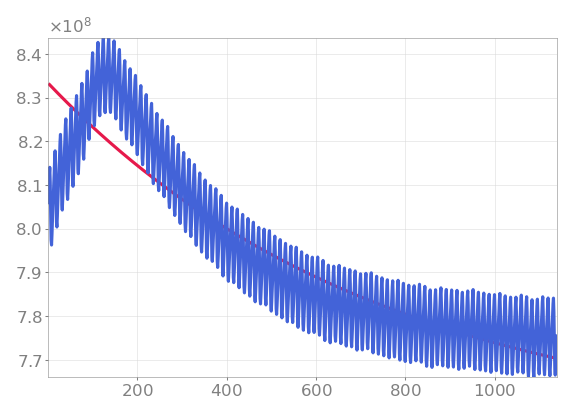

In [207]:
plt.plot(G_yr, expfunc(G_yr, *exp_par_SIA[0]))
plt.plot(G_yr, G_vol)

## Fitting a sample size of glaciers to get an idea og response times

In [191]:
def cleanup_for_nan(Data):
    mask = np.isfinite(Data)
    Data_clean = Data[mask]
    return Data_clean

def remove_zeros(Data):
    mask = Data > 0
    Data_cleaned = Data[mask]
    return Data_cleaned

def findfoldingtimes(Data, samplesize , total_parameters):
    Minimal_folding_times = []
    SIA_folding_times = []
    for i in range(samplesize):
        glacier = Alaska.iloc[i]
        G_vol = cleanup_for_nan( np.array(Data['2081-2100_hist']['Glacier volume'][i][1:]) )
        G_yr = cleanup_for_nan( np.array(Data['2081-2100_hist']['Years runtime'][i][1:]) )
        G_Temp = cleanup_for_nan(np.array(Data['2081-2100_hist']['Temperature'][i][1:]) )
        G_Precip = cleanup_for_nan(np.array(Data['2081-2100_hist']['Precipitation'][i][1:]) )
        par_model = total_parameters[i,:]
        Model_Volume = Run_linear_model(time=G_yr, l0 = Volume_to_Length(G_vol[1]), alpha_m=par_model[0], nu=par_model[1], z_offset=par_model[2], dEdT=par_model[3], df=glacier, Precip=G_Precip, temp=G_Temp)
        if not np.all(np.isfinite(Model_Volume)):
            print(max(Model_Volume))
            continue
        SIAPar = expniential_fitting(G_yr, G_vol)
        MinPar = expniential_fitting(G_yr, Model_Volume)
        Minimal_folding_times.append(1/np.abs(MinPar[0][0]))
        SIA_folding_times.append(1/np.abs(SIAPar[0][0]))

    return Minimal_folding_times,SIA_folding_times
min,sia= findfoldingtimes(loaded_data, len(total_parameters), total_parameters)

In [192]:
print(np.mean(sia)/12)
print(np.mean(min)/12)
print('years respone time')

9.039371685089975
11.214438817031903
years respone time


In [208]:
np.max(min)
np.where(min == np.max(min))
min.pop(1357)
sia.pop(1357)

751.7030016527222

In [214]:
loaded_data.keys()
init_vols = np.array(loaded_data['2081-2100_hist']['Initial volume'][:len(total_parameters)]) * 1e-9
init_vols = np.delete(init_vols, 1357)

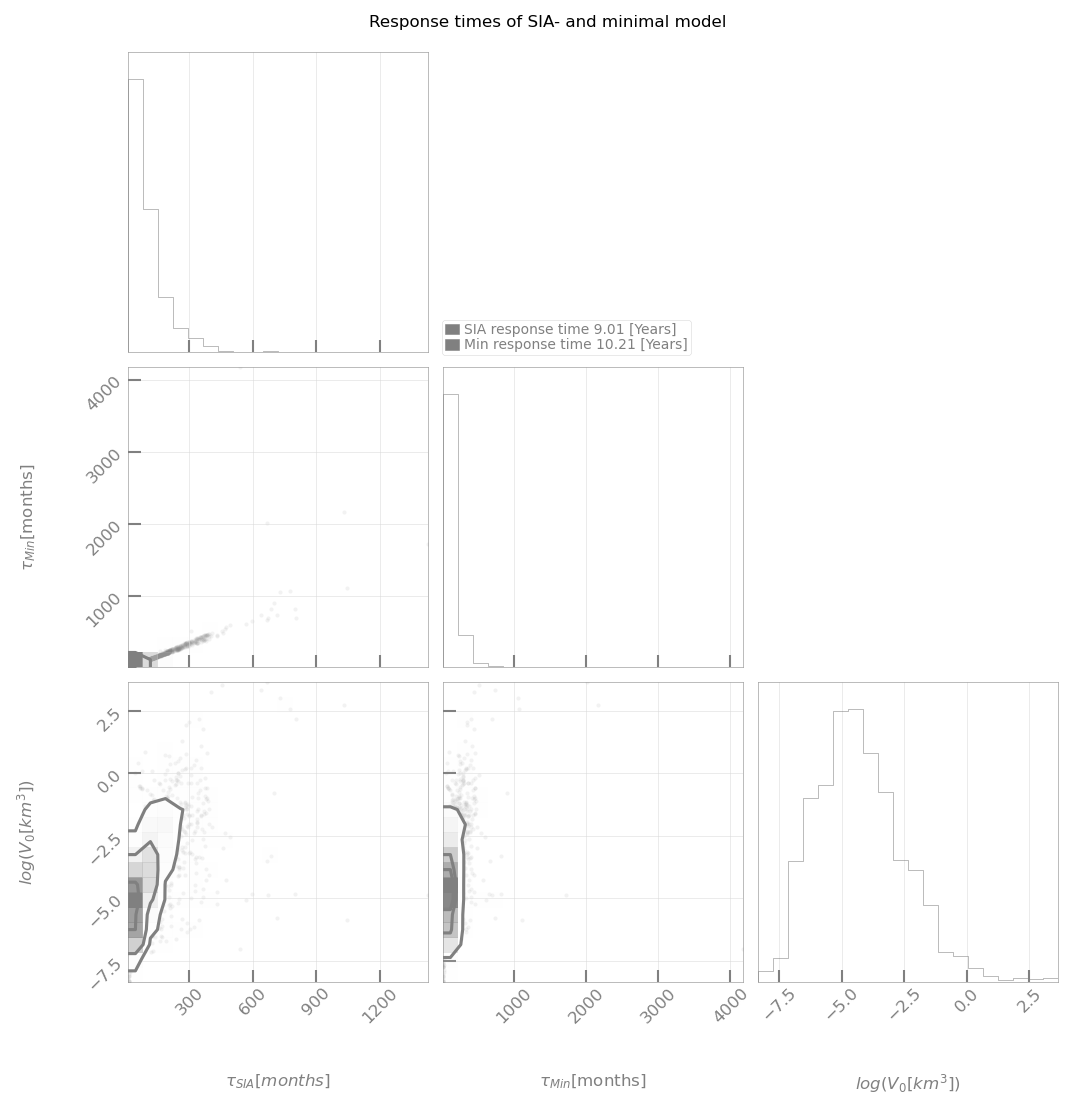

In [215]:
Tau_array = np.vstack((np.array(sia).reshape(-1), np.array(min).reshape(-1), np.log(init_vols))).T
fig = cr.corner(Tau_array, labels=[r"$\tau_{SIA}[months]$", r"$\tau_{Min}$[months]", r"$log(V_0[km^3])$"])
fig.suptitle('Response times of SIA- and minimal model')

patchSIA = mpatches.Patch(color='grey', label=f'SIA response time {np.mean(sia) / 12:.2f} [Years]')
patchMIN = mpatches.Patch(color='grey', label=f'Min response time {np.mean(min) / 12:.2f} [Years]')
handles = [patchSIA, patchMIN]

axes = fig.get_axes()
for ax in axes:
    ax.tick_params(which='major', length=6, width=1, direction='in')
    ax.tick_params(which='minor', length=3, width=1, direction='in')
fig.legend(handles=handles, loc=(0.412, 0.68))


array([False, False, False, ..., False, False, False])

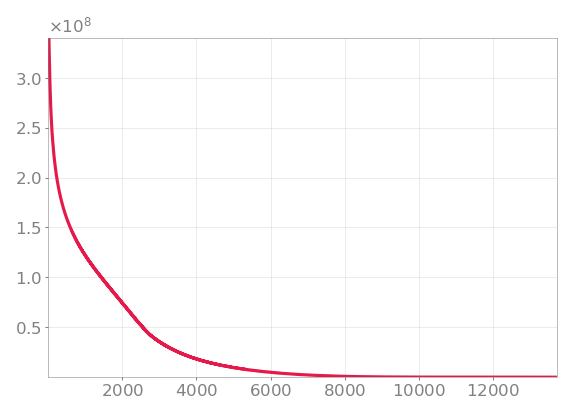

In [70]:
# G_vol = np.array(loaded_data['2081-2100_hist']['Glacier volume'][1297][1:])
# G_yr = np.array(loaded_data['2081-2100_hist']['Years runtime'][1297][1:])
# G_Temp = np.array(loaded_data['2081-2100_hist']['Temperature'][1297][1:])
# G_Precip = np.array(loaded_data['2081-2100_hist']['Precipitation'][1297][1:])
# plt.plot(G_yr, G_vol)

# finding the average parameters by fitting to the simulated data

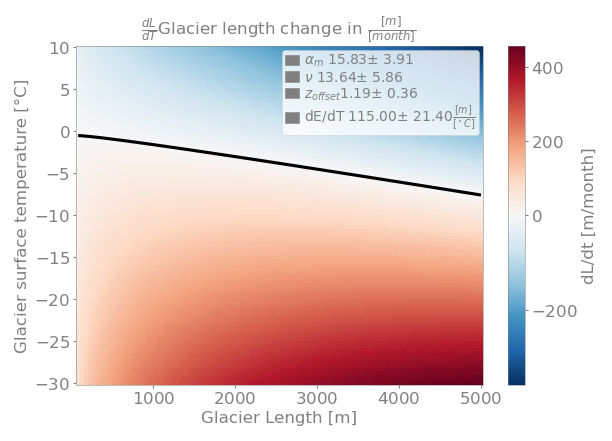

In [30]:
mean_parameters = np.mean(total_parameters, axis = 0)
# glacier = Alaska.iloc[1292]
# mean_parameters = par_fit
Lbeta = np.sqrt(G_Precip.mean()*1e-3)*0.006 * 30
Slope = np.arctan(Alaska['slope_deg']*np.pi/180)
        # const: List of physical constants [b0, s, beta, alpha_m, cl, nu, dEdT, E0, T] where:
        #       b0: Maximum elevation (m)
        #       s: Slope (radians)
        #       beta: Mass balance gradient (mm/month)
        #       alpha_m: Shape factor
        #       nu: Viscosity parameter
        #       dEdT: Temperature sensitivity (m/K)
        #       E0: Reference elevation (m)
        #       T: Temperature deviation (K)

T = np.linspace(-30,10, 100)
L = np.linspace(np.min(Alaska.lmax_m) ,5e3 , 100)
# L = np.linspace(min(Alaska.lmax_m),6000, 1000)

dldt_map = np.zeros((100,100))
for i in range(len(T)):
    for j in range(len(L)):
        const = [np.mean(Alaska.zmax_m), np.mean(Slope), Lbeta, mean_parameters[0],mean_parameters[1],mean_parameters[3],mean_parameters[2]*np.mean(Alaska.zmean_m), T[i]]
        dldt_map[i,j] = dLdt(L[j], const=const)

mesh = plt.pcolormesh(L , T, dldt_map, shading='auto', cmap='RdBu_r',norm=plt.matplotlib.colors.TwoSlopeNorm(vcenter=0) )


alpha_m_string = f'$\\alpha_m$ {mean_parameters[0]:.2f}'+f'$\\pm$ {np.std(total_parameters[:,0]):.2f}'
alpha_m_patch = mpatches.Patch(color='grey', label=alpha_m_string)
nu_string = f'$\\nu$ {mean_parameters[1]:.2f}'+f'$\\pm$ {np.std(total_parameters[:,1]):.2f}'
nu_patch = mpatches.Patch(color='grey', label=nu_string)
z_offset_string = r'$z_{offset} $'+f'{mean_parameters[2]:.2f}'+f'$\\pm$ {np.std(total_parameters[:,2]):.2f}'
z_offset_patch = mpatches.Patch(color='grey', label=z_offset_string)
dEdt_string = f'dE/dT {mean_parameters[3]:.2f}'+f'$\\pm$ {np.std(total_parameters[:,3]):.2f}' + r'$\frac{[m]}{[^\circ C]}$'
dEdT_patch = mpatches.Patch(color='grey', label=dEdt_string)
patch_handle = [alpha_m_patch, nu_patch, z_offset_patch, dEdT_patch]
plt.contour(L,T, dldt_map, levels = [0], colors = 'black')
cbar = plt.colorbar(mesh, label='dL/dt [m/month]')
cbar.locator = ticker.MaxNLocator(nbins=5)   # try 5–7 bins
cbar.update_ticks()
plt.xlabel('Glacier Length [m]')
plt.ylabel('Glacier surface temperature [°C]')
plt.title(r'$\frac{dL}{dT}$Glacier length change in $\frac{[m]}{[month]}$ ')
plt.legend(handles =patch_handle)

## Testing the emulator on a combined run


In [229]:
# Create a DataFrame with mean glacier statistics
mean_glacier_stats = {
    'slope_deg': Alaska['slope_deg'].mean(),
    'zmean_m': Alaska['zmean_m'].mean(),
    'zmin_m': Alaska['zmin_m'].mean(),  # Mean of all min elevations
    'zmax_m': Alaska['zmax_m'].mean()   # Mean of all max elevations
}
# Create a DataFrame with a single row
mean_glacier_df = pd.DataFrame([mean_glacier_stats])
summed_volumes = np.loadtxt('total_sum_array.csv', delimiter = ',')

In [273]:

Start_vol = np.sum(Volumes)
glacier = mean_glacier_df

G_Temp = np.array(loaded_data['2081-2100_hist']['Temperature'][377][1:])
G_Precip = np.array(loaded_data['2081-2100_hist']['Precipitation'][377][1:])
time_array = np.arange(0, len(G_Temp), 1)
G_vol = summed_volumes[0,1:len(G_Temp)+1]

def passfunc(time, alpha_m, nu, z_offset, dEdT):
    f = Run_linear_model(time = time,
                 alpha_m = alpha_m,
                 nu = nu,
                 l0 = Volume_to_Length(G_vol[0]),
                 dEdT = dEdT,
                 z_offset= z_offset,
                 df = mean_glacier_df,
                 Precip= G_Precip,
                 temp = G_Temp,
                 )
    return f

#set the lower parameter bounds
lower_bounds = [0, 0, 0.5, 60]
# alpha_m, nu, z_offset, dEdT
# Set upper bounds for each parameter
upper_bounds = [np.inf, np.inf, 2, 120]

# Combine into the bounds parameter
bounds = (lower_bounds, upper_bounds)

par_fit, cov = curve_fit(f =passfunc, xdata=time_array, ydata=G_vol , p0=[4,  2 , 1, 80], maxfev=100000, bounds=bounds, method='trf')


/var/folders/zm/jhkrt2q10p1fy8tnqf8pvn0r0000gn/T/ipykernel_10895/2090023891.py:88: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  L[i + 1] = L[i] + (DlDt * dt)


In [240]:
len(G_Temp)

1140

In [346]:
np.sqrt(np.diag(cov))

array([8.73424382e+04, 1.71167638e+03, 1.09297065e+00, 8.37496251e+02])

/var/folders/zm/jhkrt2q10p1fy8tnqf8pvn0r0000gn/T/ipykernel_10895/2090023891.py:88: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  L[i + 1] = L[i] + (DlDt * dt)


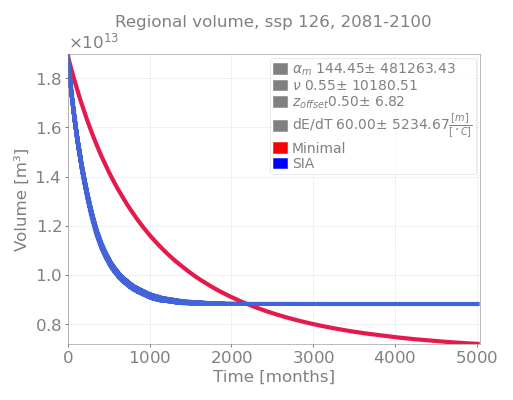

In [274]:
# glacier = Alaska.iloc[3]

Single_run = Run_linear_model(time=time_array,l0 = Volume_to_Length(G_vol[1]), alpha_m=par_fit[0], nu=par_fit[1], z_offset=par_fit[2], dEdT=par_fit[3],
                     df=glacier, Precip=G_Precip, temp=G_Temp)

alpha_m_string = f'$\\alpha_m$ {par_fit[0]:.2f}'+f'$\\pm$ {np.sqrt(cov[0,0]):.2f}'
alpha_m_patch = mpatches.Patch(color='grey', label=alpha_m_string)
nu_string = f'$\\nu$ {par_fit[1]:.2f}'+f'$\\pm$ {np.sqrt(cov[1,1]):.2f}'
nu_patch = mpatches.Patch(color='grey', label=nu_string)
z_offset_string = r'$z_{offset} $'+f'{par_fit[2]:.2f}'+f'$\\pm$ {np.sqrt(cov[2,2]):.2f}'
z_offset_patch = mpatches.Patch(color='grey', label=z_offset_string)
dEdt_string = f'dE/dT {par_fit[3]:.2f}'+f'$\\pm$ {np.sqrt(cov[3,3]):.2f}' + r'$\frac{[m]}{[^\circ C]}$'
dEdT_patch = mpatches.Patch(color='grey', label=dEdt_string)
patch_handle = [alpha_m_patch, nu_patch, z_offset_patch, dEdT_patch]

patch_glacier = mpatches.Patch(label=f'Minimal', color = 'red')
patch_metadata= mpatches.Patch(label = f'SIA', color = 'blue')
patch_handles = [alpha_m_patch, nu_patch, z_offset_patch, dEdT_patch, patch_glacier, patch_metadata]
plt.figure()
plt.plot(time_array, Single_run, label='minimal Model', linewidth=2)
plt.plot(time_array, G_vol, label='SIA', linewidth=2)
plt.xlabel('Time [months]')
plt.ylabel('Volume [m³]')
plt.title('Regional volume, ssp 126, 2081-2100')
plt.grid(True, linestyle='--')
plt.legend( handles = patch_handles)
plt.tight_layout()

In [353]:
# Single_run = Run_linear_model(time=G_yr,l0 = Volume_to_Length(Start_vol), alpha_m=mean_parameters[0], nu=mean_parameters[1], z_offset=mean_parameters[2], dEdT=mean_parameters[3], df=glacier, Precip=G_Precip, temp=G_Temp)
#
# patch_glacier = mpatches.Patch(label=f'Glacier{index}')
# patch_metadata= mpatches.Patch(label = f'ssp 126, period 2081-2100 ')
# plt.figure()
# plt.plot(G_yr, Single_run, label='minimal Model', linewidth=2)
# plt.plot(G_yr, G_vol, label='SIA', linewidth=2)
# plt.xlabel('Time [months]')
# plt.ylabel('Volume [m³]')
# plt.title('Glacier 23, ssp 126, 2081-2100')
# plt.grid(True, linestyle='--')
# plt.legend(fontsize=10)
# plt.tight_layout()

In [165]:
summed_volumes = np.loadtxt('total_sum_array.csv', delimiter = ',')

h


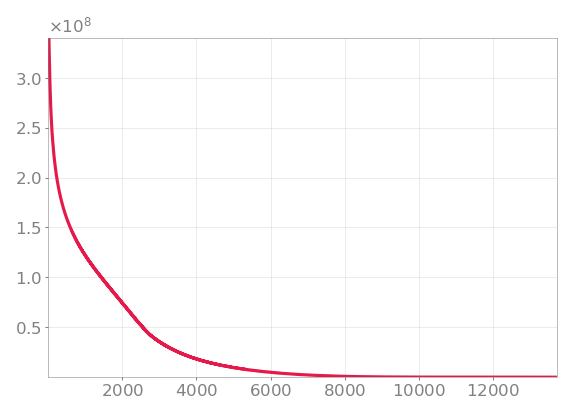

In [265]:
G_vol = np.array(loaded_data['2081-2100_hist']['Glacier volume'][1297][1:])
G_yr = np.array(loaded_data['2081-2100_hist']['Years runtime'][1297][1:])
G_Temp = np.array(loaded_data['2081-2100_hist']['Temperature'][1297][1:])
G_Precip = np.array(loaded_data['2081-2100_hist']['Precipitation'][1297][1:])
plt.plot(G_yr, G_vol)

In [290]:
# Create a DataFrame with mean glacier statistics
mean_glacier_stats = {
    'slope_deg': Alaska['slope_deg'].mean(),
    'zmean_m': Alaska['zmean_m'].mean(),
    'zmin_m': Alaska['zmin_m'].mean(),  # Mean of all min elevations
    'zmax_m': Alaska['zmax_m'].mean()   # Mean of all max elevations
}
# Create a DataFrame with a single row
mean_glacier_df = pd.DataFrame([mean_glacier_stats])
# summed_volumes = np.loadtxt('total_sum_array.csv', delimiter = ',')

In [258]:
glacier = mean_glacier_df
G_Temp = np.array(loaded_data['2081-2100_hist']['Temperature'][1297][1:])
G_Precip = np.array(loaded_data['2081-2100_hist']['Precipitation'][1297][1:])
time_array = np.arange(0, len(G_Precip), 1)
#
minimal_runs = []

for i in tqdm(range(len(loaded_data['2081-2100_hist']['Glacier volume'][:]))):
    glacier = Alaska.iloc[i]
    G_vol = loaded_data['2081-2100_hist']['Glacier volume'][i][1:]
    Single_run = Run_linear_model(time=G_yr, l0 = Volume_to_Length(G_vol[1]), alpha_m=mean_parameters[0], nu=mean_parameters[1], z_offset=mean_parameters[2], dEdT=mean_parameters[3], df=glacier, Precip=G_Precip, temp=G_Temp)
    minimal_runs.append(Single_run)


  0%|          | 0/2000 [00:00<?, ?it/s]

IndexError: index 1140 is out of bounds for axis 0 with size 1140

In [268]:
max_len = max([len(np.array(loaded_data['2081-2100_hist']['Precipitation'][i][1:])) for i in range(1144) ])
np.where(max_len == np.array([len(np.array(loaded_data['2081-2100_hist']['Precipitation'][i][1:])) for i in range(1144) ]))

(array([377]),)

In [250]:
len(loaded_data['2081-2100_hist']['Precipitation'][:][0])

1141

In [254]:
np.array(loaded_data['2081-2100_hist']['Precipitation'][2][1:]).shape

(1140,)

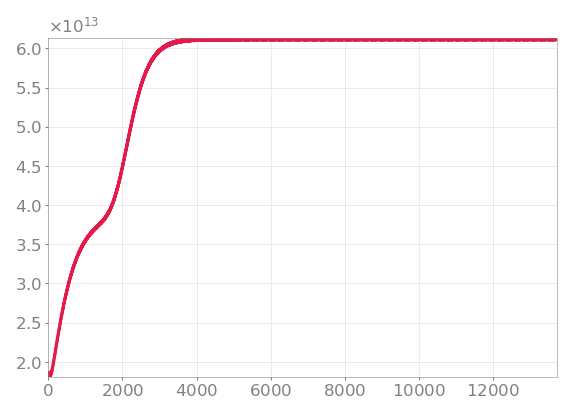

In [320]:
plt.plot(G_yr,np.sum(np.vstack(minimal_runs), axis = 0) )

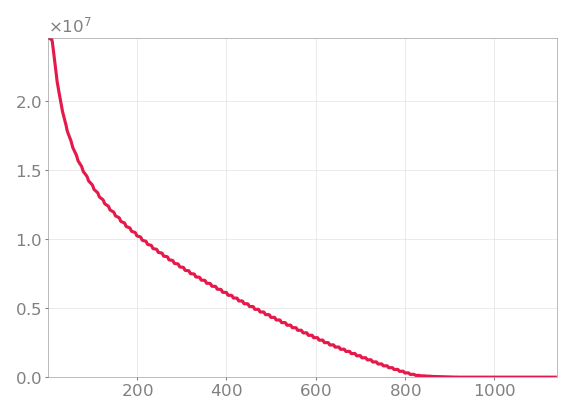

In [306]:
index = 2097
glacier = Alaska.iloc[index]
periods = ['2081-2100_hist']
G_vol = loaded_data[periods[0]]['Glacier volume'][index][1:]
G_yr = loaded_data[periods[0]]['Years runtime'][index][1:]
G_Temp = loaded_data[periods[0]]['Temperature'][index][1:]
G_Precip = loaded_data[periods[0]]['Precipitation'][index][1:]
plt.plot(G_yr, G_vol)

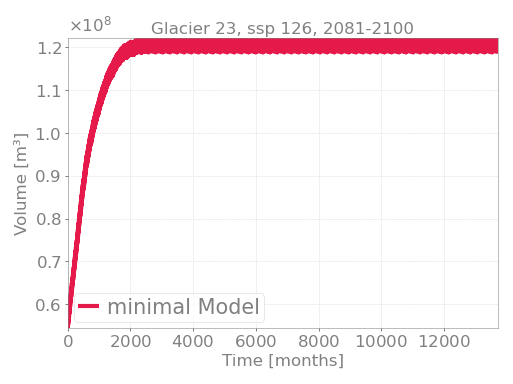

In [313]:
index = 2000
glacier = mean_glacier_df
time_array = np.arange(0, len(G_Temp), 1)
G_yr = time_array
G_Temp = np.array(loaded_data['2081-2100_hist']['Temperature'][1297][1:])
G_Precip = np.array(loaded_data['2081-2100_hist']['Precipitation'][1297][1:])
G_vol = loaded_data[periods[0]]['Glacier volume'][index][1:]

Single_run = Run_linear_model(time=G_yr,l0 = Volume_to_Length(G_vol[1]), alpha_m=mean_parameters[0], nu=mean_parameters[1], z_offset=mean_parameters[2], dEdT=mean_parameters[3], df=glacier, Precip=G_Precip, temp=G_Temp)

patch_glacier = mpatches.Patch(label=f'Glacier{index}')
patch_metadata= mpatches.Patch(label = f'ssp 126, period 2081-2100 ')
plt.figure()
plt.plot(G_yr, Single_run, label='minimal Model', linewidth=2)
# plt.plot(G_yr, G_vol, label='SIA', linewidth=2)
plt.xlabel('Time [months]')
plt.ylabel('Volume [m³]')
plt.title('Glacier 23, ssp 126, 2081-2100')
plt.grid(True, linestyle='--')
plt.legend(fontsize=10)
plt.tight_layout()

In [235]:
len(G_vol)
# G_Temp = np.array(loaded_data['2081-2100_hist']['Temperature'][1297][1:])
# G_Precip = np.array(loaded_data['2081-2100_hist']['Precipitation'][1297][1:])
# G_vol = loaded_data[periods[0]]['Glacier volume'][index][1:]

1129